In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
drive.mount('/content/drive')
train_df=pd.read_csv('/content/drive/MyDrive/ECG/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/MyDrive/ECG/mitbih_test.csv',header=None)

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
train_df[187] = train_df[187].astype(int)

In [ ]:
df_0 = (train_df[train_df[187] == 0]).sample(n=20000, random_state=42)
df_1 = train_df[train_df[187] == 1]
df_2 = train_df[train_df[187] == 2]
df_3 = train_df[train_df[187] == 3]
df_4 = train_df[train_df[187] == 4]
df_1_upsample = resample(df_1, replace=True, n_samples=20000, random_state=123)
df_2_upsample = resample(df_2, replace=True, n_samples=20000, random_state=124)
df_3_upsample = resample(df_3, replace=True, n_samples=20000, random_state=125)
df_4_upsample = resample(df_4, replace=True, n_samples=20000, random_state=126)
train_df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])
X = train_df.drop(columns=[187]).values
y = train_df[187].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = to_categorical(y, num_classes=5)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(80000, 187) (80000, 5) (20000, 187) (20000, 5)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 118s 46ms/step - accuracy: 0.7800 - loss: 0.5975 - val_accuracy: 0.9215 - val_loss: 0.2178
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 146s 48ms/step - accuracy: 0.8933 - loss: 0.2901 - val_accuracy: 0.9504 - val_loss: 0.1512
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 137s 46ms/step - accuracy: 0.9186 - loss: 0.2235 - val_accuracy: 0.9632 - val_loss: 0.1151
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 145s 47ms/step - accuracy: 0.9309 - loss: 0.1962 - val_accuracy: 0.9655 - val_loss: 0.1002
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 114s 45ms/step - accuracy: 0.9372 - loss: 0.1720 - val_accuracy: 0.9707 - val_loss: 0.0876
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 145s 47ms/step - accuracy: 0.9441 - loss: 0.1568 - val_accuracy: 0.9733 - val_loss: 0.0835
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 148s 49ms/step - accuracy: 0.9476 - loss: 0.1432 - val_accuracy: 0.9751 - val_loss: 0.0714
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 115s 46ms/step - accuracy: 

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9797 - loss: 0.0598
Test accuracy: 0.981249988079071
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
Confusion matrix:
[[3787  127   42   52   10]
 [  42 3963    6    4    0]
 [  17   10 3922   52    1]
 [   0    0    0 3987    0]
 [   6    2    4    0 3966]]


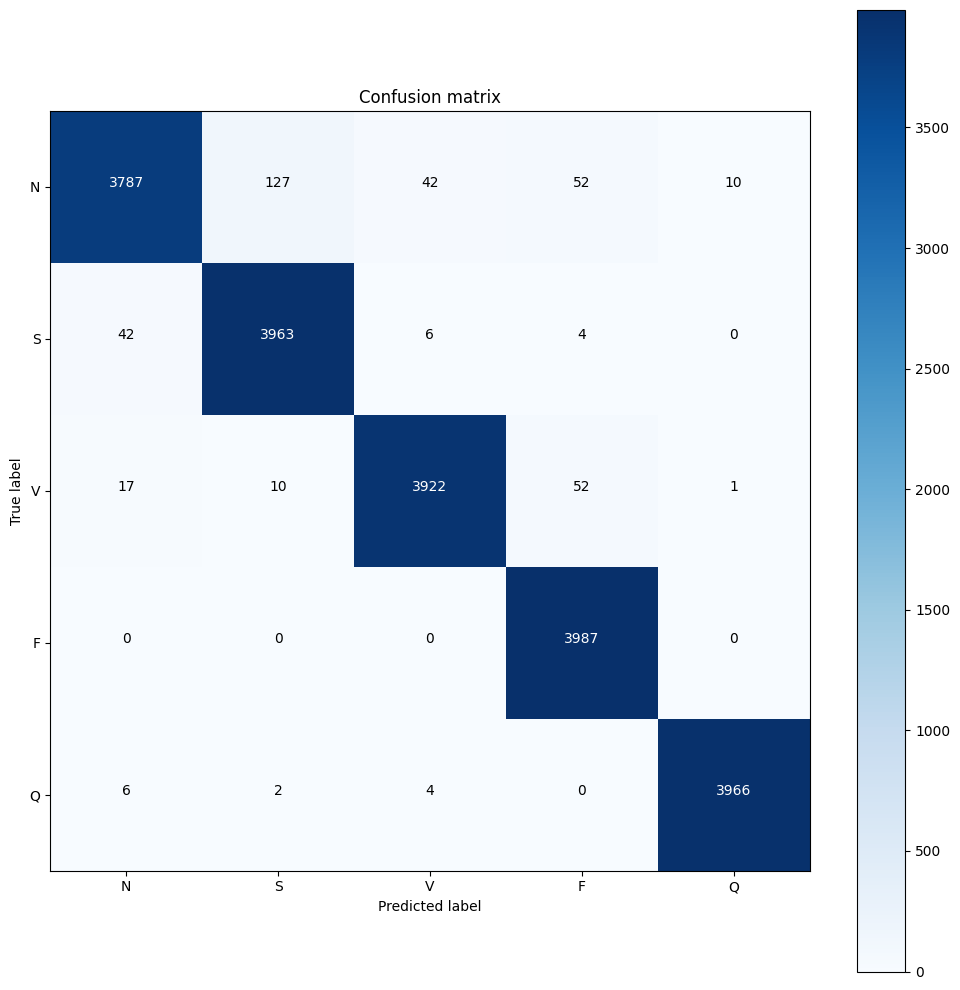

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_acc}')
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
cnf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred_classes)
print("Confusion matrix:")
print(cnf_matrix)
def plot_confusion_matrix(cm, classes, title="Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=["N", "S", "V", "F", "Q"], title="Confusion matrix")
plt.show()

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for i in range(100):
        yield [X_val[i:i+1].astype(np.float32)]
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
model_path = '/content/drive/MyDrive/ECG/ecg_model2.tflite'
with open(model_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmphressuju'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139855285314832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139855285313680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139855285316752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139855285314640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139855285317328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139855285319824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139855285316944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139855285321168: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
model_path = '/content/drive/MyDrive/ECG/ecg_model2.tflite'
model_data = model_path
with open(model_data, 'rb') as f:
    tflite_model = f.read()
header_file_path = '/content/drive/MyDrive/ECG/model_data2.h'
with open(header_file_path, 'w') as f:
    f.write('#ifndef MODEL_DATA_H\n')
    f.write('#define MODEL_DATA_H\n\n')
    f.write('#include <stdint.h>\n\n')
    f.write('const uint8_t model_data[] = {\n')
    f.write(','.join([f'0x{x:02x}' for x in tflite_model]))
    f.write('\n};\n\n')
    f.write('#endif  // MODEL_DATA_H\n')

In [ ]:
!pip install tensorflow_model_optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.1 MB/s eta 0:00:00
